## TOY PROJECT 04 - 네이버 영화 감성분석
네이버 영화 사이트의 영화 리뷰 감성을 분석합니다. 


### 1. 라이브러리 및 데이터 불러오기
데이터 핸들링을 위해 `pandas`,   
한국어 자연어처리를 위해 `konlpy`,    
__를 위해 `gensim` 라이브러리를 활용합니다.

In [1]:
def print_lib_ver(lib):
    print(f"{lib.__name__}: {lib.__version__}")

import numpy as np
import pandas as pd
import konlpy
import gensim

import tensorflow as tf
import matplotlib.pyplot as plt

print_lib_ver(pd)
print_lib_ver(konlpy)
print_lib_ver(gensim)
print_lib_ver(tf)


pandas: 1.3.3
konlpy: 0.5.2
gensim: 4.1.2
tensorflow: 2.6.0


In [2]:
import os

def data_path(data_name):
    return f"{os.getcwd()}/data/{data_name}"

train_data = pd.read_table(data_path('ratings_train.txt'))
test_data = pd.read_table(data_path('ratings_test.txt'))

print(len(train_data), len(test_data))
train_data.head(3)


150000 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 2. 데이터 로더 - 형태소 전환 및 단어 인덱스로 변환

In [3]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 훈련 데이터의 중복&결측 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) 
    train_data = train_data.dropna(how = 'any') 
    
    # 테스트 데이터의 중복&결측 데이터 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 훈련 데이터 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    # 테스트 데이터 토큰화 및 불용어 제거
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 단어 텍스트 리스트를 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # 정제된 X_train, X_test 데이터
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # 각각 X_train, y_train, X_test, y_test, word_to_index → 전처리 후 데이터 반환   
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}


### 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터 셋 내부 문장 길이 분포 확인  
- 적절한 최대 문장 길이 지정  
- keras ~ pad_sequence를 활용한 패딩 추가 


In [4]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


#### 적절한 최대 문장 길이는 무엇을 기준으로 판단하는가?

In [5]:
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen: ', maxlen)
print(f'전체 문장의 {round(np.sum(num_tokens < max_tokens) / len(num_tokens), 5) * 100}%가 maxlen 설정값 이내에 포함됩니다.')


pad_sequences maxlen:  54
전체 문장의 97.209%가 maxlen 설정값 이내에 포함됩니다.


#### pad_sequence로 padding 적용

In [7]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)


(146182, 54)


### 4. 모델 구성 및 validation set 구성  

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)


#### 4.1. CNN

In [9]:
model_cnn = tf.keras.Sequential(name = "model_cnn")
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()


Model: "model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9 

#### 4.2. CNN - Global Maxpooling

In [10]:
model_cnnglobal = tf.keras.Sequential(name = "model_cnn_global")
model_cnnglobal.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnnglobal.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnnglobal.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnnglobal.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnnglobal.summary()


Model: "model_cnn_global"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 4.3. RNN

In [11]:
model_rnn = tf.keras.Sequential(name='model_rnn')
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()


Model: "model_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시


In [47]:
# validation set 10000건 분리
X_val = X_train[:5000]
y_val = y_train[:5000]

# validation set을 제외한 나머지 136182 건
partial_X_train = X_train[5000:]
partial_y_train = y_train[5000:]

print(partial_X_train.shape)
print(partial_y_train.shape)


(141182, 54)
(141182,)


In [40]:
epochs = 20
models = [model_cnn, model_cnnglobal, model_rnn]

list_history = []

for model in models:
    model.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])
    
    print("==== ==== ==== ==== ==== ==== ==== ====")
    print(f"model name: {model._name} started fitting!")
    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)
    
    list_history.append(history)
    

==== ==== ==== ==== ==== ==== ==== ====
model name: model_cnn started fitting!
Epoch 1/20
227/227 [==============================] - 2s 7ms/step - loss: 0.0445 - accuracy: 0.9860 - val_loss: 0.3743 - val_accuracy: 0.9274
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.4041 - val_accuracy: 0.9224
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0325 - accuracy: 0.9896 - val_loss: 0.4279 - val_accuracy: 0.9175
Epoch 4/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0312 - accuracy: 0.9897 - val_loss: 0.4581 - val_accuracy: 0.9136
Epoch 5/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.4893 - val_accuracy: 0.9099
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0275 - accuracy: 0.9905 - val_loss: 0.5255 - val_accuracy: 0.9050
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - l

In [41]:
dict_history = {f'model {i+1}': dict(history.history) for i, history in enumerate(list_history)}
dict_history


{'model 1': {'loss': [0.04449190944433212,
   0.03625618293881416,
   0.032490406185388565,
   0.031232226639986038,
   0.02899138256907463,
   0.027521518990397453,
   0.026915499940514565,
   0.025275414809584618,
   0.025172516703605652,
   0.026104534044861794,
   0.02460389956831932,
   0.02372012287378311,
   0.020897630602121353,
   0.018692107871174812,
   0.017348960041999817,
   0.017104510217905045,
   0.017831644043326378,
   0.01962599903345108,
   0.02306284010410309,
   0.022531801834702492],
  'accuracy': [0.9859874844551086,
   0.9886987805366516,
   0.9896455407142639,
   0.9896713495254517,
   0.9904546141624451,
   0.9905493259429932,
   0.9906439781188965,
   0.9914358258247375,
   0.9911776185035706,
   0.9907214641571045,
   0.9911518096923828,
   0.99144446849823,
   0.9928646683692932,
   0.9933035969734192,
   0.9940007925033569,
   0.9936478734016418,
   0.9934327006340027,
   0.9925978183746338,
   0.9914358258247375,
   0.9915477633476257],
  'val_loss': [0

### 6. Loss, Accuracy 그래프 시각화


In [15]:
dict_history.keys()


dict_keys(['model 1', 'model 2', 'model 3'])

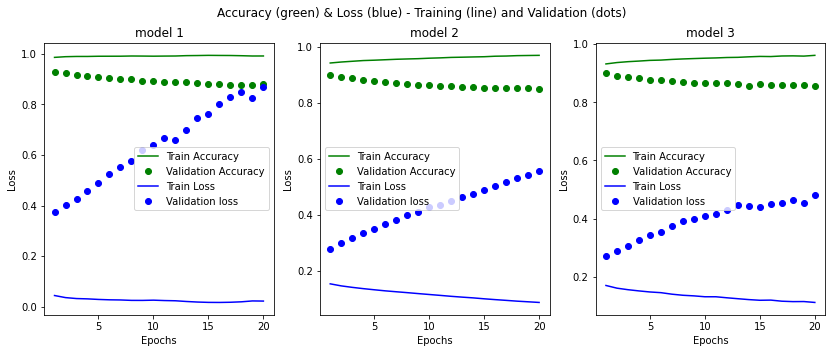

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

plt.suptitle("Accuracy (green) & Loss (blue) - Training (line) and Validation (dots)")

for ax, key in zip(axes, dict_history.keys()):    
    history = dict_history[key]
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    ax.plot(epochs, acc, 'g', label='Train Accuracy')  
    ax.plot(epochs, val_acc, 'go', label = 'Validation Accuracy')
    ax.plot(epochs, loss, 'b', label='Train Loss')
    ax.plot(epochs, val_loss, 'bo', label='Validation loss')
    
    ax.set_title(key)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    ax.legend()

plt.show()


### 7. 학습된 Embedding Layer 분석
CNN_globalpading을 활용한 두번째 모델의 Embedding layer를 분석합니다

#### 7.1. 모델 가중치 추출, txt 파일로 저장

In [17]:
model = models[1] # 2번째 모델, CNN_global padding
embedding_layer = model.layers[0] # 모델의 첫번째 레이어
weights = embedding_layer.get_weights()[0] # 첫째 레이어 가중치

print(weights.shape) # 10000개 데이터, 16개 가중치


(10000, 16)


In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getcwd()+'\\data\\word2vec.txt'
f = open(word2vec_file_path, 'w', encoding='utf-8')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 특수문자를 제외한 단어 개수만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


#### 7.2. Layer 분석

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

vector = word_vectors['영화'] # 단어 '영화'의 벡터를 확인합니다.
vector


array([-0.03010311, -0.27930492, -0.30399364, -0.32059574, -0.30298725,
       -0.27729824, -0.28625712, -0.24455455, -0.27632025,  0.04576806,
       -0.32231197, -0.18537967, -0.27548265, -0.2638803 , -0.29328313,
       -0.27966404], dtype=float32)

In [20]:
word_vectors.similar_by_word("좋아") # '좋아'라는 단어와 유사한 단어, 그리고 유하도를 확인합니다.


[('유지태', 0.9277904033660889),
 ('겁니다', 0.9203526973724365),
 ('빛', 0.8930075168609619),
 ('단연', 0.8927716612815857),
 ('조니뎁', 0.8895019292831421),
 ('바랍니다', 0.8871263265609741),
 ('이민호', 0.8846578001976013),
 ('지났', 0.8827442526817322),
 ('나루토', 0.8818188905715942),
 ('기독교인', 0.8779119253158569)]

In [21]:
word_vectors.similar_by_word("극장") # '극장'이란 단어와 유사한 단어, 그리고 유하도를 확인합니다.


[('약', 0.8446627259254456),
 ('다큐멘터리', 0.8347374796867371),
 ('바랬', 0.8329272866249084),
 ('욱', 0.8256258368492126),
 ('허구', 0.8232550621032715),
 ('~~~~~', 0.8160954117774963),
 ('웃', 0.8135363459587097),
 ('과도', 0.8054661154747009),
 ('모양', 0.7997688055038452),
 ('나요', 0.7962436079978943)]

### 8. 한국어 word2vec 임베딩 활용해 성능 개선

#### 8.1. 한국어 word2vec 임베딩 모델 호출 및 벡터 확인

In [22]:
kword2vec_path = os.getenv('HOME') + '/data/word2vec_ko.model'
kword2vec = Word2VecKeyedVectors.load(kword2vec_path)
kword2vec = kword2vec.wv # 한국어 word2vec의 단어 벡터는 .wv에 저장되어 있어 변수를 다시 지정합니다.


In [23]:
vector = kword2vec['영화']
print(vector)

vector.shape # dim=100의 단어 벡터


[-1.8007389  -1.1790098  -2.4066596   2.1384156  -0.3537603   1.3749527
 -4.894612   -3.6517198   0.4411444   0.78153926 -2.696888   -1.7812852
 -2.1514654  -4.813236    2.7465918  -2.1620324  -0.11467794 -1.2431171
  2.3979309  -1.1060628  -0.41043055  1.9500391   0.7821002   1.5899978
  1.6447444  -2.1265035  -1.7981595   1.7535795   0.53717697 -1.212121
 -4.466316    4.5488324   1.334441   -0.9070271   1.1931889   4.1563215
  1.9758307  -0.9437562  -0.2592725   0.34935686  1.8562875  -3.3249645
  1.1221625   1.2836524   3.9211376   3.8023994   2.766269    0.67293745
  2.2853644  -5.1131716   0.32525915 -3.3079958   5.3043513  -3.8813758
 -0.32960036 -1.9527504   3.8865075  -3.5470378  -0.21991685  0.82119733
 -0.9492492   3.5472107   1.322048   -0.70640826  0.52253807  1.4683235
 -1.1018689   2.262941   -0.7204685  -1.766201    5.2237577   3.0748682
  1.0977576   3.3191733  -0.4100423  -1.7022891  -0.78379875  0.82586575
 -0.54520637  1.2355382   2.02674    -0.652447    1.0866054   

(100,)

In [24]:
kword2vec.similar_by_word('좋') # '좋아'가 key에 없기 때문에 어근 '좋'을 입력


[('괜찮', 0.7750421762466431),
 ('많', 0.7747864127159119),
 ('높', 0.7699527740478516),
 ('낮', 0.7429317831993103),
 ('귀찮', 0.715669572353363),
 ('밝', 0.7056754231452942),
 ('알맞', 0.6912494897842407),
 ('나쁘', 0.6896841526031494),
 ('언짢', 0.6774056553840637),
 ('짧', 0.6383933424949646)]

In [25]:
kword2vec.similar_by_word('극장') # 극장과 단어 유사도 확인


[('공연장', 0.734738826751709),
 ('영화관', 0.7285679578781128),
 ('오페라단', 0.7239658832550049),
 ('오페라', 0.7214334607124329),
 ('소극장', 0.7028483152389526),
 ('콘서트홀', 0.6995508074760437),
 ('살롱', 0.6894219517707825),
 ('음악당', 0.6769198775291443),
 ('발레단', 0.6662783622741699),
 ('관현악단', 0.6594403982162476)]

#### 8.2. 모델 구성 및 적용

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kword2vec:
        embedding_matrix[i] = kword2vec[index_to_word[i]]

In [50]:
from tensorflow.keras.initializers import Constant

# 모델 구성 - RNN
model_rnn_kword2vec = tf.keras.Sequential(name='model_rnn_kword2vec')
model_rnn_kword2vec.add(tf.keras.layers.Embedding(vocab_size, 
                                             word_vector_dim, 
                                             embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                             input_length=maxlen, 
                                             trainable=True))
model_rnn_kword2vec.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn_kword2vec.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn_kword2vec.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn_kword2vec.summary()


Model: "model_rnn_kword2vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 학습의 진행
model_rnn_kword2vec.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_rnn_kword2vec.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
276/276 [==============================] - 4s 9ms/step - loss: 0.6737 - accuracy: 0.5410 - val_loss: 0.5530 - val_accuracy: 0.7218
Epoch 2/10
276/276 [==============================] - 2s 8ms/step - loss: 0.4341 - accuracy: 0.8018 - val_loss: 0.3905 - val_accuracy: 0.8256
Epoch 3/10
276/276 [==============================] - 2s 8ms/step - loss: 0.3443 - accuracy: 0.8504 - val_loss: 0.3346 - val_accuracy: 0.8518
Epoch 4/10
276/276 [==============================] - 2s 8ms/step - loss: 0.3052 - accuracy: 0.8695 - val_loss: 0.3233 - val_accuracy: 0.8612
Epoch 5/10
276/276 [==============================] - 2s 8ms/step - loss: 0.2809 - accuracy: 0.8823 - val_loss: 0.3236 - val_accuracy: 0.8604
Epoch 6/10
276/276 [==============================] - 2s 8ms/step - loss: 0.2628 - accuracy: 0.8906 - val_loss: 0.3191 - val_accuracy: 0.8638
Epoch 7/10
276/276 [==============================] - 2s 8ms/step - loss: 0.2473 - accuracy: 0.8981 - val_loss: 0.3173 - val_accuracy: 0.8656
Epoch 

In [52]:
# 테스트셋을 통한 모델 평가
results = model_rnn_kword2vec.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3605 - accuracy: 0.8596
[0.36054518818855286, 0.8595520257949829]


In [45]:
history = history.history
    
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)


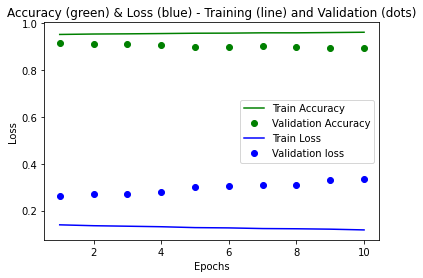

In [46]:
plt.title("Accuracy (green) & Loss (blue) - Training (line) and Validation (dots)")

plt.plot(epochs, acc, 'g', label='Train Accuracy')  
plt.plot(epochs, val_acc, 'go', label = 'Validation Accuracy')
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()


#### 